# Sciplex Dose

In [1]:
ood_seed = 6

In [2]:
num_ood = 1

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

52

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Dex', '100.0'), 790)


Removed datapoint: 790

train         11219
validation     2802
ood             790
Name: split, dtype: int64

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="condition",
    control_group="Vehicle",
    dosage_key="dose_val",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['cell_type']
)

  0%|          | 0/14811 [00:00<?, ?it/s]

 46%|████▌     | 6839/14811 [00:00<00:00, 68384.36it/s]

 94%|█████████▍| 13959/14811 [00:00<00:00, 70038.74it/s]

100%|██████████| 14811/14811 [00:00<00:00, 69429.50it/s]

  0%|          | 0/14811 [00:00<?, ?it/s]

100%|██████████| 14811/14811 [00:00<00:00, 933910.17it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [13]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [14]:
model.train(max_epochs=400)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 134.93it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:09<1:01:43,  9.28s/it]

Epoch 1/400:   0%|          | 1/400 [00:09<1:01:43,  9.28s/it, v_num=1, recon=3.1e+3, r2_mean=0.117, adv_loss=1.48, acc_pert=0.339]

Epoch 2/400:   0%|          | 1/400 [00:09<1:01:43,  9.28s/it, v_num=1, recon=3.1e+3, r2_mean=0.117, adv_loss=1.48, acc_pert=0.339]

Epoch 2/400:   0%|          | 2/400 [00:12<39:39,  5.98s/it, v_num=1, recon=3.1e+3, r2_mean=0.117, adv_loss=1.48, acc_pert=0.339]  

Epoch 2/400:   0%|          | 2/400 [00:12<39:39,  5.98s/it, v_num=1, recon=2.36e+3, r2_mean=0.483, adv_loss=1.25, acc_pert=0.491]

Epoch 3/400:   0%|          | 2/400 [00:12<39:39,  5.98s/it, v_num=1, recon=2.36e+3, r2_mean=0.483, adv_loss=1.25, acc_pert=0.491]

Epoch 3/400:   1%|          | 3/400 [00:16<33:25,  5.05s/it, v_num=1, recon=2.36e+3, r2_mean=0.483, adv_loss=1.25, acc_pert=0.491]

Epoch 3/400:   1%|          | 3/400 [00:16<33:25,  5.05s/it, v_num=1, recon=2.21e+3, r2_mean=0.605, adv_loss=1.13, acc_pert=0.554]

Epoch 4/400:   1%|          | 3/400 [00:16<33:25,  5.05s/it, v_num=1, recon=2.21e+3, r2_mean=0.605, adv_loss=1.13, acc_pert=0.554]

Epoch 4/400:   1%|          | 4/400 [00:21<31:12,  4.73s/it, v_num=1, recon=2.21e+3, r2_mean=0.605, adv_loss=1.13, acc_pert=0.554]

Epoch 4/400:   1%|          | 4/400 [00:21<31:12,  4.73s/it, v_num=1, recon=2.16e+3, r2_mean=0.665, adv_loss=1.04, acc_pert=0.609]

Epoch 5/400:   1%|          | 4/400 [00:21<31:12,  4.73s/it, v_num=1, recon=2.16e+3, r2_mean=0.665, adv_loss=1.04, acc_pert=0.609]

Epoch 5/400:   1%|▏         | 5/400 [00:27<34:05,  5.18s/it, v_num=1, recon=2.16e+3, r2_mean=0.665, adv_loss=1.04, acc_pert=0.609]

Epoch 5/400:   1%|▏         | 5/400 [00:27<34:05,  5.18s/it, v_num=1, recon=2.14e+3, r2_mean=0.71, adv_loss=0.968, acc_pert=0.648]

Epoch 6/400:   1%|▏         | 5/400 [00:27<34:05,  5.18s/it, v_num=1, recon=2.14e+3, r2_mean=0.71, adv_loss=0.968, acc_pert=0.648]

Epoch 6/400:   2%|▏         | 6/400 [00:30<29:38,  4.51s/it, v_num=1, recon=2.14e+3, r2_mean=0.71, adv_loss=0.968, acc_pert=0.648]

Epoch 6/400:   2%|▏         | 6/400 [00:30<29:38,  4.51s/it, v_num=1, recon=2.13e+3, r2_mean=0.738, adv_loss=0.92, acc_pert=0.667]

Epoch 7/400:   2%|▏         | 6/400 [00:30<29:38,  4.51s/it, v_num=1, recon=2.13e+3, r2_mean=0.738, adv_loss=0.92, acc_pert=0.667]

Epoch 7/400:   2%|▏         | 7/400 [00:34<28:04,  4.29s/it, v_num=1, recon=2.13e+3, r2_mean=0.738, adv_loss=0.92, acc_pert=0.667]

Epoch 7/400:   2%|▏         | 7/400 [00:34<28:04,  4.29s/it, v_num=1, recon=2.12e+3, r2_mean=0.761, adv_loss=0.899, acc_pert=0.677]

Epoch 8/400:   2%|▏         | 7/400 [00:34<28:04,  4.29s/it, v_num=1, recon=2.12e+3, r2_mean=0.761, adv_loss=0.899, acc_pert=0.677]

Epoch 8/400:   2%|▏         | 8/400 [00:37<26:25,  4.04s/it, v_num=1, recon=2.12e+3, r2_mean=0.761, adv_loss=0.899, acc_pert=0.677]

Epoch 8/400:   2%|▏         | 8/400 [00:37<26:25,  4.04s/it, v_num=1, recon=2.12e+3, r2_mean=0.779, adv_loss=0.881, acc_pert=0.68] 

Epoch 9/400:   2%|▏         | 8/400 [00:37<26:25,  4.04s/it, v_num=1, recon=2.12e+3, r2_mean=0.779, adv_loss=0.881, acc_pert=0.68]

Epoch 9/400:   2%|▏         | 9/400 [00:40<24:46,  3.80s/it, v_num=1, recon=2.12e+3, r2_mean=0.779, adv_loss=0.881, acc_pert=0.68]

Epoch 9/400:   2%|▏         | 9/400 [00:40<24:46,  3.80s/it, v_num=1, recon=2.11e+3, r2_mean=0.796, adv_loss=0.862, acc_pert=0.689]

Epoch 10/400:   2%|▏         | 9/400 [00:40<24:46,  3.80s/it, v_num=1, recon=2.11e+3, r2_mean=0.796, adv_loss=0.862, acc_pert=0.689]


disnt_basal = 0.39612253692237026

disnt_after = 0.3963745862837385

val_r2_mean = 0.806594796072353

val_r2_var = 0.2827578441663222


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:54<44:42,  6.88s/it, v_num=1, recon=2.11e+3, r2_mean=0.796, adv_loss=0.862, acc_pert=0.689]

Epoch 10/400:   2%|▎         | 10/400 [00:54<44:42,  6.88s/it, v_num=1, recon=2.11e+3, r2_mean=0.81, adv_loss=0.855, acc_pert=0.692, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:54<44:42,  6.88s/it, v_num=1, recon=2.11e+3, r2_mean=0.81, adv_loss=0.855, acc_pert=0.692, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:58<37:44,  5.82s/it, v_num=1, recon=2.11e+3, r2_mean=0.81, adv_loss=0.855, acc_pert=0.692, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:58<37:44,  5.82s/it, v_num=1, recon=2.1e+3, r2_mean=0.823, adv_loss=0.841, acc_pert=0.697, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:58<37:44,  5.82s/it, v_num=1, recon=2.1e+3, r2_mean=0.823, adv_loss=0.841, acc_pert=0.697, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:01<33:18,  5.15s/it, v_num=1, recon=2.1e+3, r2_mean=0.823, adv_loss=0.841, acc_pert=0.697, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:01<33:18,  5.15s/it, v_num=1, recon=2.1e+3, r2_mean=0.83, adv_loss=0.83, acc_pert=0.699, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]  

Epoch 13/400:   3%|▎         | 12/400 [01:01<33:18,  5.15s/it, v_num=1, recon=2.1e+3, r2_mean=0.83, adv_loss=0.83, acc_pert=0.699, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:06<32:42,  5.07s/it, v_num=1, recon=2.1e+3, r2_mean=0.83, adv_loss=0.83, acc_pert=0.699, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:06<32:42,  5.07s/it, v_num=1, recon=2.1e+3, r2_mean=0.838, adv_loss=0.824, acc_pert=0.701, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [01:06<32:42,  5.07s/it, v_num=1, recon=2.1e+3, r2_mean=0.838, adv_loss=0.824, acc_pert=0.701, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:11<32:21,  5.03s/it, v_num=1, recon=2.1e+3, r2_mean=0.838, adv_loss=0.824, acc_pert=0.701, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:11<32:21,  5.03s/it, v_num=1, recon=2.1e+3, r2_mean=0.845, adv_loss=0.821, acc_pert=0.704, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [01:11<32:21,  5.03s/it, v_num=1, recon=2.1e+3, r2_mean=0.845, adv_loss=0.821, acc_pert=0.704, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:16<31:58,  4.98s/it, v_num=1, recon=2.1e+3, r2_mean=0.845, adv_loss=0.821, acc_pert=0.704, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:16<31:58,  4.98s/it, v_num=1, recon=2.09e+3, r2_mean=0.85, adv_loss=0.811, acc_pert=0.704, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [01:16<31:58,  4.98s/it, v_num=1, recon=2.09e+3, r2_mean=0.85, adv_loss=0.811, acc_pert=0.704, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:19<29:04,  4.54s/it, v_num=1, recon=2.09e+3, r2_mean=0.85, adv_loss=0.811, acc_pert=0.704, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:19<29:04,  4.54s/it, v_num=1, recon=2.09e+3, r2_mean=0.854, adv_loss=0.8, acc_pert=0.711, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan] 

Epoch 17/400:   4%|▍         | 16/400 [01:19<29:04,  4.54s/it, v_num=1, recon=2.09e+3, r2_mean=0.854, adv_loss=0.8, acc_pert=0.711, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:23<27:51,  4.37s/it, v_num=1, recon=2.09e+3, r2_mean=0.854, adv_loss=0.8, acc_pert=0.711, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:23<27:51,  4.37s/it, v_num=1, recon=2.09e+3, r2_mean=0.858, adv_loss=0.795, acc_pert=0.713, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [01:23<27:51,  4.37s/it, v_num=1, recon=2.09e+3, r2_mean=0.858, adv_loss=0.795, acc_pert=0.713, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:27<26:50,  4.22s/it, v_num=1, recon=2.09e+3, r2_mean=0.858, adv_loss=0.795, acc_pert=0.713, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:27<26:50,  4.22s/it, v_num=1, recon=2.09e+3, r2_mean=0.863, adv_loss=0.795, acc_pert=0.709, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [01:27<26:50,  4.22s/it, v_num=1, recon=2.09e+3, r2_mean=0.863, adv_loss=0.795, acc_pert=0.709, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:31<26:08,  4.12s/it, v_num=1, recon=2.09e+3, r2_mean=0.863, adv_loss=0.795, acc_pert=0.709, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:31<26:08,  4.12s/it, v_num=1, recon=2.08e+3, r2_mean=0.867, adv_loss=0.782, acc_pert=0.719, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:31<26:08,  4.12s/it, v_num=1, recon=2.08e+3, r2_mean=0.867, adv_loss=0.782, acc_pert=0.719, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]


disnt_basal = 0.41263502223709597

disnt_after = 0.41259836382637366

val_r2_mean = 0.864097684621811

val_r2_var = 0.3499366678974845


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:45<44:37,  7.05s/it, v_num=1, recon=2.08e+3, r2_mean=0.867, adv_loss=0.782, acc_pert=0.719, val_recon=2.13e+3, disnt_basal=0.396, disnt_after=0.396, val_r2_mean=0.807, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:45<44:37,  7.05s/it, v_num=1, recon=2.08e+3, r2_mean=0.869, adv_loss=0.779, acc_pert=0.715, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan] 

Epoch 21/400:   5%|▌         | 20/400 [01:45<44:37,  7.05s/it, v_num=1, recon=2.08e+3, r2_mean=0.869, adv_loss=0.779, acc_pert=0.715, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:50<39:54,  6.32s/it, v_num=1, recon=2.08e+3, r2_mean=0.869, adv_loss=0.779, acc_pert=0.715, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:50<39:54,  6.32s/it, v_num=1, recon=2.08e+3, r2_mean=0.874, adv_loss=0.781, acc_pert=0.719, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:50<39:54,  6.32s/it, v_num=1, recon=2.08e+3, r2_mean=0.874, adv_loss=0.781, acc_pert=0.719, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:55<38:06,  6.05s/it, v_num=1, recon=2.08e+3, r2_mean=0.874, adv_loss=0.781, acc_pert=0.719, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:55<38:06,  6.05s/it, v_num=1, recon=2.08e+3, r2_mean=0.875, adv_loss=0.768, acc_pert=0.725, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [01:55<38:06,  6.05s/it, v_num=1, recon=2.08e+3, r2_mean=0.875, adv_loss=0.768, acc_pert=0.725, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:59<33:33,  5.34s/it, v_num=1, recon=2.08e+3, r2_mean=0.875, adv_loss=0.768, acc_pert=0.725, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:59<33:33,  5.34s/it, v_num=1, recon=2.07e+3, r2_mean=0.877, adv_loss=0.77, acc_pert=0.718, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan] 

Epoch 24/400:   6%|▌         | 23/400 [01:59<33:33,  5.34s/it, v_num=1, recon=2.07e+3, r2_mean=0.877, adv_loss=0.77, acc_pert=0.718, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [02:03<30:41,  4.90s/it, v_num=1, recon=2.07e+3, r2_mean=0.877, adv_loss=0.77, acc_pert=0.718, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [02:03<30:41,  4.90s/it, v_num=1, recon=2.07e+3, r2_mean=0.88, adv_loss=0.767, acc_pert=0.724, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [02:03<30:41,  4.90s/it, v_num=1, recon=2.07e+3, r2_mean=0.88, adv_loss=0.767, acc_pert=0.724, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [02:07<29:01,  4.64s/it, v_num=1, recon=2.07e+3, r2_mean=0.88, adv_loss=0.767, acc_pert=0.724, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [02:07<29:01,  4.64s/it, v_num=1, recon=2.07e+3, r2_mean=0.882, adv_loss=0.762, acc_pert=0.719, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [02:07<29:01,  4.64s/it, v_num=1, recon=2.07e+3, r2_mean=0.882, adv_loss=0.762, acc_pert=0.719, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [02:15<35:58,  5.77s/it, v_num=1, recon=2.07e+3, r2_mean=0.882, adv_loss=0.762, acc_pert=0.719, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [02:15<35:58,  5.77s/it, v_num=1, recon=2.07e+3, r2_mean=0.883, adv_loss=0.759, acc_pert=0.722, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [02:15<35:58,  5.77s/it, v_num=1, recon=2.07e+3, r2_mean=0.883, adv_loss=0.759, acc_pert=0.722, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:19<31:59,  5.15s/it, v_num=1, recon=2.07e+3, r2_mean=0.883, adv_loss=0.759, acc_pert=0.722, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:19<31:59,  5.15s/it, v_num=1, recon=2.06e+3, r2_mean=0.886, adv_loss=0.752, acc_pert=0.731, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [02:19<31:59,  5.15s/it, v_num=1, recon=2.06e+3, r2_mean=0.886, adv_loss=0.752, acc_pert=0.731, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:23<30:21,  4.90s/it, v_num=1, recon=2.06e+3, r2_mean=0.886, adv_loss=0.752, acc_pert=0.731, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:23<30:21,  4.90s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.754, acc_pert=0.728, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [02:23<30:21,  4.90s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.754, acc_pert=0.728, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:26<27:06,  4.39s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.754, acc_pert=0.728, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:26<27:06,  4.39s/it, v_num=1, recon=2.06e+3, r2_mean=0.888, adv_loss=0.746, acc_pert=0.73, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan] 

Epoch 30/400:   7%|▋         | 29/400 [02:26<27:06,  4.39s/it, v_num=1, recon=2.06e+3, r2_mean=0.888, adv_loss=0.746, acc_pert=0.73, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]


disnt_basal = 0.41865068305811765

disnt_after = 0.4195442992408092

val_r2_mean = 0.8844379208304664

val_r2_var = 0.3695738250559027


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [02:43<50:38,  8.21s/it, v_num=1, recon=2.06e+3, r2_mean=0.888, adv_loss=0.746, acc_pert=0.73, val_recon=2.1e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.864, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [02:43<50:38,  8.21s/it, v_num=1, recon=2.06e+3, r2_mean=0.889, adv_loss=0.748, acc_pert=0.732, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [02:43<50:38,  8.21s/it, v_num=1, recon=2.06e+3, r2_mean=0.889, adv_loss=0.748, acc_pert=0.732, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:48<42:59,  6.99s/it, v_num=1, recon=2.06e+3, r2_mean=0.889, adv_loss=0.748, acc_pert=0.732, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:48<42:59,  6.99s/it, v_num=1, recon=2.06e+3, r2_mean=0.889, adv_loss=0.736, acc_pert=0.736, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [02:48<42:59,  6.99s/it, v_num=1, recon=2.06e+3, r2_mean=0.889, adv_loss=0.736, acc_pert=0.736, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:52<38:28,  6.27s/it, v_num=1, recon=2.06e+3, r2_mean=0.889, adv_loss=0.736, acc_pert=0.736, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:52<38:28,  6.27s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.736, acc_pert=0.739, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [02:52<38:28,  6.27s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.736, acc_pert=0.739, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:56<33:28,  5.47s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.736, acc_pert=0.739, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:56<33:28,  5.47s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.729, acc_pert=0.738, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [02:56<33:28,  5.47s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.729, acc_pert=0.738, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:59<29:35,  4.85s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.729, acc_pert=0.738, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:59<29:35,  4.85s/it, v_num=1, recon=2.05e+3, r2_mean=0.892, adv_loss=0.727, acc_pert=0.743, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [02:59<29:35,  4.85s/it, v_num=1, recon=2.05e+3, r2_mean=0.892, adv_loss=0.727, acc_pert=0.743, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [03:04<28:59,  4.77s/it, v_num=1, recon=2.05e+3, r2_mean=0.892, adv_loss=0.727, acc_pert=0.743, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [03:04<28:59,  4.77s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.723, acc_pert=0.738, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [03:04<28:59,  4.77s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.723, acc_pert=0.738, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [03:07<26:20,  4.34s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.723, acc_pert=0.738, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [03:07<26:20,  4.34s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.731, acc_pert=0.735, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [03:07<26:20,  4.34s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.731, acc_pert=0.735, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [03:11<25:58,  4.29s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.731, acc_pert=0.735, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [03:11<25:58,  4.29s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.727, acc_pert=0.742, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [03:11<25:58,  4.29s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.727, acc_pert=0.742, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [03:15<25:21,  4.20s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.727, acc_pert=0.742, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [03:15<25:21,  4.20s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.719, acc_pert=0.747, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [03:15<25:21,  4.20s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.719, acc_pert=0.747, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [03:21<28:32,  4.74s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.719, acc_pert=0.747, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [03:21<28:32,  4.74s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.723, acc_pert=0.74, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan] 

Epoch 40/400:  10%|▉         | 39/400 [03:21<28:32,  4.74s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.723, acc_pert=0.74, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]


disnt_basal = 0.419138623036339

disnt_after = 0.42017611187539566

val_r2_mean = 0.8946863028136167

val_r2_var = 0.38980024348605763


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [03:42<57:30,  9.58s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.723, acc_pert=0.74, val_recon=2.09e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.884, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [03:42<57:30,  9.58s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.715, acc_pert=0.746, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [03:42<57:30,  9.58s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.715, acc_pert=0.746, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:46<46:12,  7.72s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.715, acc_pert=0.746, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:46<46:12,  7.72s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.71, acc_pert=0.749, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan] 

Epoch 42/400:  10%|█         | 41/400 [03:46<46:12,  7.72s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.71, acc_pert=0.749, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:49<38:39,  6.48s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.71, acc_pert=0.749, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:49<38:39,  6.48s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.711, acc_pert=0.749, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [03:49<38:39,  6.48s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.711, acc_pert=0.749, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:57<40:55,  6.88s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.711, acc_pert=0.749, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:57<40:55,  6.88s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.71, acc_pert=0.746, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan] 

Epoch 44/400:  11%|█         | 43/400 [03:57<40:55,  6.88s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.71, acc_pert=0.746, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [04:00<34:38,  5.84s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.71, acc_pert=0.746, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [04:00<34:38,  5.84s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.712, acc_pert=0.744, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [04:00<34:38,  5.84s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.712, acc_pert=0.744, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [04:06<34:33,  5.84s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.712, acc_pert=0.744, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [04:06<34:33,  5.84s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.707, acc_pert=0.75, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan] 

Epoch 46/400:  11%|█▏        | 45/400 [04:06<34:33,  5.84s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.707, acc_pert=0.75, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [04:11<33:16,  5.64s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.707, acc_pert=0.75, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [04:11<33:16,  5.64s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.714, acc_pert=0.744, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [04:11<33:16,  5.64s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.714, acc_pert=0.744, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [04:16<32:04,  5.45s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.714, acc_pert=0.744, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [04:16<32:04,  5.45s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.71, acc_pert=0.749, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan] 

Epoch 48/400:  12%|█▏        | 47/400 [04:16<32:04,  5.45s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.71, acc_pert=0.749, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [04:20<28:56,  4.93s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.71, acc_pert=0.749, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [04:20<28:56,  4.93s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.705, acc_pert=0.751, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [04:20<28:56,  4.93s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.705, acc_pert=0.751, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [04:24<26:23,  4.51s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.705, acc_pert=0.751, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [04:24<26:23,  4.51s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.701, acc_pert=0.749, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [04:24<26:23,  4.51s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.701, acc_pert=0.749, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.42467117208596417

disnt_after = 0.4255304548310716

val_r2_mean = 0.8931864034045828

val_r2_var = 0.40796020572835745


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [04:46<57:24,  9.84s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.701, acc_pert=0.749, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [04:46<57:24,  9.84s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.704, acc_pert=0.751, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [04:46<57:24,  9.84s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.704, acc_pert=0.751, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:49<45:59,  7.91s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.704, acc_pert=0.751, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:49<45:59,  7.91s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.705, acc_pert=0.749, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [04:49<45:59,  7.91s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.705, acc_pert=0.749, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:53<38:52,  6.70s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.705, acc_pert=0.749, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:53<38:52,  6.70s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.703, acc_pert=0.749, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [04:53<38:52,  6.70s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.703, acc_pert=0.749, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [05:00<39:13,  6.78s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.703, acc_pert=0.749, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [05:00<39:13,  6.78s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.749, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [05:00<39:13,  6.78s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.749, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [05:05<35:27,  6.15s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.749, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [05:05<35:27,  6.15s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.708, acc_pert=0.751, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [05:05<35:27,  6.15s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.708, acc_pert=0.751, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [05:09<31:39,  5.51s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.708, acc_pert=0.751, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [05:09<31:39,  5.51s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.703, acc_pert=0.752, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [05:09<31:39,  5.51s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.703, acc_pert=0.752, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [05:12<27:59,  4.88s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.703, acc_pert=0.752, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [05:12<27:59,  4.88s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.7, acc_pert=0.749, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]  

Epoch 57/400:  14%|█▍        | 56/400 [05:12<27:59,  4.88s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.7, acc_pert=0.749, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [05:16<26:15,  4.59s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.7, acc_pert=0.749, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [05:16<26:15,  4.59s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.704, acc_pert=0.749, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [05:16<26:15,  4.59s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.704, acc_pert=0.749, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [05:20<24:35,  4.31s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.704, acc_pert=0.749, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [05:20<24:35,  4.31s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.699, acc_pert=0.747, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [05:20<24:35,  4.31s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.699, acc_pert=0.747, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [05:23<22:36,  3.98s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.699, acc_pert=0.747, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [05:23<22:36,  3.98s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.751, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [05:23<22:36,  3.98s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.751, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.42768209042426125

disnt_after = 0.4288590114371588

val_r2_mean = 0.8898285963318565

val_r2_var = 0.4132266077128324

Epoch 60/400:  15%|█▌        | 60/400 [05:37<39:17,  6.93s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.692, acc_pert=0.751, val_recon=2.07e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.893, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [05:37<39:17,  6.93s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan] 

Epoch 61/400:  15%|█▌        | 60/400 [05:37<39:17,  6.93s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:41<33:59,  6.02s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:41<33:59,  6.02s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.697, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [05:41<33:59,  6.02s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.697, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:44<29:24,  5.22s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.697, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:44<29:24,  5.22s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.751, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan] 

Epoch 63/400:  16%|█▌        | 62/400 [05:44<29:24,  5.22s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.751, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:47<26:01,  4.63s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.751, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:47<26:01,  4.63s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.698, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [05:47<26:01,  4.63s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.698, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:51<23:43,  4.24s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.698, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:51<23:43,  4.24s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.693, acc_pert=0.754, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]  

Epoch 65/400:  16%|█▌        | 64/400 [05:51<23:43,  4.24s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.693, acc_pert=0.754, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:54<22:02,  3.95s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.693, acc_pert=0.754, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:54<22:02,  3.95s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.753, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [05:54<22:02,  3.95s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.753, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:57<20:57,  3.77s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.753, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:57<20:57,  3.77s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.751, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [05:57<20:57,  3.77s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.751, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [06:01<20:06,  3.62s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.751, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [06:01<20:06,  3.62s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.688, acc_pert=0.751, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [06:01<20:06,  3.62s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.688, acc_pert=0.751, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [06:04<19:19,  3.49s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.688, acc_pert=0.751, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [06:04<19:19,  3.49s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]  

Epoch 69/400:  17%|█▋        | 68/400 [06:04<19:19,  3.49s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [06:07<18:47,  3.41s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [06:07<18:47,  3.41s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan] 

Epoch 70/400:  17%|█▋        | 69/400 [06:07<18:47,  3.41s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.4298163996542316

disnt_after = 0.43124968252091417

val_r2_mean = 0.8987080135128714

val_r2_var = 0.41694094484502614


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [06:25<42:32,  7.74s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.89, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [06:25<42:32,  7.74s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.688, acc_pert=0.751, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]  

Epoch 71/400:  18%|█▊        | 70/400 [06:25<42:32,  7.74s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.688, acc_pert=0.751, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [06:28<35:06,  6.40s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.688, acc_pert=0.751, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [06:28<35:06,  6.40s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.691, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [06:28<35:06,  6.40s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.691, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:32<30:11,  5.52s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.691, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:32<30:11,  5.52s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.681, acc_pert=0.755, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [06:32<30:11,  5.52s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.681, acc_pert=0.755, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [06:35<26:22,  4.84s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.681, acc_pert=0.755, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [06:35<26:22,  4.84s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.688, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [06:35<26:22,  4.84s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.688, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:38<23:47,  4.38s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.688, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:38<23:47,  4.38s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.681, acc_pert=0.755, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]  

Epoch 75/400:  18%|█▊        | 74/400 [06:38<23:47,  4.38s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.681, acc_pert=0.755, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:42<22:33,  4.16s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.681, acc_pert=0.755, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:42<22:33,  4.16s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.683, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [06:42<22:33,  4.16s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.683, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:45<21:08,  3.91s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.683, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:45<21:08,  3.91s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.682, acc_pert=0.757, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]  

Epoch 77/400:  19%|█▉        | 76/400 [06:45<21:08,  3.91s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.682, acc_pert=0.757, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:49<21:11,  3.94s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.682, acc_pert=0.757, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:49<21:11,  3.94s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.68, acc_pert=0.753, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [06:49<21:11,  3.94s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.68, acc_pert=0.753, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:52<20:12,  3.77s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.68, acc_pert=0.753, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:52<20:12,  3.77s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.678, acc_pert=0.755, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [06:52<20:12,  3.77s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.678, acc_pert=0.755, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:56<19:36,  3.67s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.678, acc_pert=0.755, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:56<19:36,  3.67s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.674, acc_pert=0.76, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan] 

Epoch 80/400:  20%|█▉        | 79/400 [06:56<19:36,  3.67s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.674, acc_pert=0.76, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.43042426030051006

disnt_after = 0.4321330630729195

val_r2_mean = 0.8970022315328771

val_r2_var = 0.4237661031159488


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [07:12<38:39,  7.25s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.674, acc_pert=0.76, val_recon=2.06e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.899, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [07:12<38:39,  7.25s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [07:12<38:39,  7.25s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [07:15<33:17,  6.26s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [07:15<33:17,  6.26s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan] 

Epoch 82/400:  20%|██        | 81/400 [07:15<33:17,  6.26s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [07:19<28:37,  5.40s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [07:19<28:37,  5.40s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.674, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [07:19<28:37,  5.40s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.674, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [07:24<27:22,  5.18s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.674, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [07:24<27:22,  5.18s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]  

Epoch 84/400:  21%|██        | 83/400 [07:24<27:22,  5.18s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:27<24:35,  4.67s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:27<24:35,  4.67s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.676, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [07:27<24:35,  4.67s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.676, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:30<22:27,  4.28s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.676, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:30<22:27,  4.28s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [07:30<22:27,  4.28s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:34<20:59,  4.01s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:34<20:59,  4.01s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [07:34<20:59,  4.01s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:37<20:19,  3.90s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:37<20:19,  3.90s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan] 

Epoch 88/400:  22%|██▏       | 87/400 [07:37<20:19,  3.90s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:41<19:47,  3.81s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:41<19:47,  3.81s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [07:41<19:47,  3.81s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:45<20:10,  3.89s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:45<20:10,  3.89s/it, v_num=1, recon=1.99e+3, r2_mean=0.903, adv_loss=0.662, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [07:45<20:10,  3.89s/it, v_num=1, recon=1.99e+3, r2_mean=0.903, adv_loss=0.662, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.4316880377770092

disnt_after = 0.43305802557600725

val_r2_mean = 0.8914423509077594

val_r2_var = 0.43085797429084777

Epoch 90/400:  22%|██▎       | 90/400 [08:06<46:07,  8.93s/it, v_num=1, recon=1.99e+3, r2_mean=0.903, adv_loss=0.662, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.897, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [08:06<46:07,  8.93s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.674, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [08:06<46:07,  8.93s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.674, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [08:10<39:21,  7.64s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.674, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [08:10<39:21,  7.64s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [08:10<39:21,  7.64s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [08:15<34:55,  6.80s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [08:15<34:55,  6.80s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan] 

Epoch 93/400:  23%|██▎       | 92/400 [08:15<34:55,  6.80s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [08:19<30:28,  5.96s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [08:19<30:28,  5.96s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [08:19<30:28,  5.96s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [08:23<26:26,  5.18s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [08:23<26:26,  5.18s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan] 

Epoch 95/400:  24%|██▎       | 94/400 [08:23<26:26,  5.18s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [08:26<23:32,  4.63s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [08:26<23:32,  4.63s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [08:26<23:32,  4.63s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [08:29<21:31,  4.25s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [08:29<21:31,  4.25s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.671, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan] 

Epoch 97/400:  24%|██▍       | 96/400 [08:29<21:31,  4.25s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.671, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [08:33<20:47,  4.12s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.671, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [08:33<20:47,  4.12s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.665, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [08:33<20:47,  4.12s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.665, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [08:36<19:30,  3.88s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.665, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [08:36<19:30,  3.88s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [08:36<19:30,  3.88s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:40<18:39,  3.72s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:40<18:39,  3.72s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [08:40<18:39,  3.72s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]


disnt_basal = 0.430903625578485

disnt_after = 0.4318676918875832

val_r2_mean = 0.8940600536086343

val_r2_var = 0.4429071252996271


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [08:55<36:28,  7.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.891, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [08:55<36:28,  7.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [08:55<36:28,  7.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:59<31:04,  6.23s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:59<31:04,  6.23s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [08:59<31:04,  6.23s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [09:03<27:08,  5.47s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [09:03<27:08,  5.47s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [09:03<27:08,  5.47s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [09:06<23:50,  4.82s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [09:06<23:50,  4.82s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.664, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [09:06<23:50,  4.82s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.664, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [09:10<21:49,  4.42s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.664, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [09:10<21:49,  4.42s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan] 

Epoch 105/400:  26%|██▌       | 104/400 [09:10<21:49,  4.42s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [09:13<20:36,  4.19s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [09:13<20:36,  4.19s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.66, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [09:13<20:36,  4.19s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.66, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [09:17<19:07,  3.90s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.66, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [09:17<19:07,  3.90s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.663, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [09:17<19:07,  3.90s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.663, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [09:20<18:01,  3.69s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.663, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [09:20<18:01,  3.69s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [09:20<18:01,  3.69s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [09:23<17:21,  3.57s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [09:23<17:21,  3.57s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.658, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [09:23<17:21,  3.57s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.658, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [09:26<16:52,  3.48s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.658, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [09:26<16:52,  3.48s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan] 

Epoch 110/400:  27%|██▋       | 109/400 [09:26<16:52,  3.48s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4298195142558922

disnt_after = 0.4308175446580296

val_r2_mean = 0.8972517761317165

val_r2_var = 0.43391791148619224

Epoch 110/400:  28%|██▊       | 110/400 [09:37<27:51,  5.76s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.894, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [09:37<27:51,  5.76s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [09:37<27:51,  5.76s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:41<24:50,  5.16s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:41<24:50,  5.16s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan] 

Epoch 112/400:  28%|██▊       | 111/400 [09:41<24:50,  5.16s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:45<22:16,  4.64s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:45<22:16,  4.64s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [09:45<22:16,  4.64s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:48<20:31,  4.29s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:48<20:31,  4.29s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [09:48<20:31,  4.29s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:52<19:21,  4.06s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:52<19:21,  4.06s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [09:52<19:21,  4.06s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:55<18:26,  3.88s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:55<18:26,  3.88s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [09:55<18:26,  3.88s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:58<17:43,  3.75s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:58<17:43,  3.75s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan] 

Epoch 117/400:  29%|██▉       | 116/400 [09:58<17:43,  3.75s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [10:02<17:15,  3.66s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [10:02<17:15,  3.66s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [10:02<17:15,  3.66s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [10:05<16:42,  3.56s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [10:05<16:42,  3.56s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [10:05<16:42,  3.56s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [10:09<16:55,  3.61s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [10:09<16:55,  3.61s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.653, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [10:09<16:55,  3.61s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.653, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.42896402410206974

disnt_after = 0.430467631123286

val_r2_mean = 0.8894198265942662

val_r2_var = 0.4505344775590029

Epoch 120/400:  30%|███       | 120/400 [10:22<29:53,  6.41s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.653, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.43, disnt_after=0.431, val_r2_mean=0.897, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [10:22<29:53,  6.41s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [10:22<29:53,  6.41s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [10:26<26:31,  5.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [10:26<26:31,  5.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [10:26<26:31,  5.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [10:29<22:59,  4.96s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [10:29<22:59,  4.96s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan] 

Epoch 123/400:  30%|███       | 122/400 [10:29<22:59,  4.96s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [10:33<21:08,  4.58s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [10:33<21:08,  4.58s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [10:33<21:08,  4.58s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [10:36<19:13,  4.18s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [10:36<19:13,  4.18s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [10:36<19:13,  4.18s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [10:39<18:03,  3.94s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [10:39<18:03,  3.94s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan] 

Epoch 126/400:  31%|███▏      | 125/400 [10:39<18:03,  3.94s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [10:43<17:04,  3.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [10:43<17:04,  3.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [10:43<17:04,  3.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [10:46<16:17,  3.58s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [10:46<16:17,  3.58s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [10:46<16:17,  3.58s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [10:50<16:12,  3.58s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [10:50<16:12,  3.58s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.655, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [10:50<16:12,  3.58s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.655, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:53<15:47,  3.50s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.655, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:53<15:47,  3.50s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [10:53<15:47,  3.50s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.42892333403048594

disnt_after = 0.43010882772872316

val_r2_mean = 0.8879311745817012

val_r2_var = 0.45565495003353457


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [11:01<21:23,  4.75s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.889, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [11:01<21:23,  4.75s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [11:01<21:23,  4.75s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [11:04<19:29,  4.35s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [11:04<19:29,  4.35s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [11:04<19:29,  4.35s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [11:07<18:17,  4.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [11:07<18:17,  4.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.65, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan] 

Epoch 133/400:  33%|███▎      | 132/400 [11:07<18:17,  4.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.65, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:11<17:12,  3.87s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.65, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:11<17:12,  3.87s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [11:11<17:12,  3.87s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [11:14<16:21,  3.69s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [11:14<16:21,  3.69s/it, v_num=1, recon=1.96e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan] 

Epoch 135/400:  34%|███▎      | 134/400 [11:14<16:21,  3.69s/it, v_num=1, recon=1.96e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [11:17<15:41,  3.55s/it, v_num=1, recon=1.96e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [11:17<15:41,  3.55s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.648, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [11:17<15:41,  3.55s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.648, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [11:21<15:31,  3.53s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.648, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [11:21<15:31,  3.53s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [11:21<15:31,  3.53s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [11:24<15:03,  3.44s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [11:24<15:03,  3.44s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [11:24<15:03,  3.44s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [11:27<14:46,  3.38s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [11:27<14:46,  3.38s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [11:27<14:46,  3.38s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [11:31<14:39,  3.37s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [11:31<14:39,  3.37s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [11:31<14:39,  3.37s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.42451754414666

disnt_after = 0.42591812162862547

val_r2_mean = 0.8994351663372734

val_r2_var = 0.4423503978685899


Epoch 00139: cpa_metric reached. Module best state updated.


Epoch 140/400:  35%|███▌      | 140/400 [11:39<20:52,  4.82s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.888, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [11:39<20:52,  4.82s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [11:39<20:52,  4.82s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [11:42<18:58,  4.39s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [11:42<18:58,  4.39s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [11:42<18:58,  4.39s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [11:45<17:30,  4.07s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [11:46<17:30,  4.07s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [11:46<17:30,  4.07s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [11:49<16:41,  3.90s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [11:49<16:41,  3.90s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [11:49<16:41,  3.90s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [11:55<19:57,  4.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [11:55<19:57,  4.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.648, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [11:55<19:57,  4.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.648, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [11:59<18:00,  4.24s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.648, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [11:59<18:00,  4.24s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.648, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [11:59<18:00,  4.24s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.648, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [12:02<16:42,  3.95s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.648, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [12:02<16:42,  3.95s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [12:02<16:42,  3.95s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [12:05<15:47,  3.75s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [12:05<15:47,  3.75s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]  

Epoch 148/400:  37%|███▋      | 147/400 [12:05<15:47,  3.75s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [12:08<14:58,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [12:08<14:58,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [12:08<14:58,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [12:12<14:47,  3.54s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [12:12<14:47,  3.54s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [12:12<14:47,  3.54s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.43150077343281795

disnt_after = 0.43271639031799486

val_r2_mean = 0.8956135809421539

val_r2_var = 0.443722082268108

Epoch 150/400:  38%|███▊      | 150/400 [12:25<26:33,  6.37s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [12:25<26:33,  6.37s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan] 

Epoch 151/400:  38%|███▊      | 150/400 [12:25<26:33,  6.37s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [12:34<30:08,  7.26s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [12:34<30:08,  7.26s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.646, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [12:34<30:08,  7.26s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.646, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [12:38<25:48,  6.24s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.646, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [12:38<25:48,  6.24s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [12:38<25:48,  6.24s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [12:42<22:29,  5.47s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [12:42<22:29,  5.47s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [12:42<22:29,  5.47s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [12:46<20:34,  5.02s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [12:46<20:34,  5.02s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [12:46<20:34,  5.02s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [12:49<18:29,  4.53s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [12:49<18:29,  4.53s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [12:49<18:29,  4.53s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [12:53<17:13,  4.23s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [12:53<17:13,  4.23s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [12:53<17:13,  4.23s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [12:56<16:07,  3.98s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [12:56<16:07,  3.98s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [12:56<16:07,  3.98s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [13:00<15:32,  3.85s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [13:00<15:32,  3.85s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [13:00<15:32,  3.85s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [13:03<14:57,  3.72s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [13:03<14:57,  3.72s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.646, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [13:03<14:57,  3.72s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.646, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.42671338151673316

disnt_after = 0.4282366058168996

val_r2_mean = 0.8972788767381149

val_r2_var = 0.4476301171562889


Epoch 00159: cpa_metric reached. Module best state updated.


Epoch 160/400:  40%|████      | 160/400 [13:13<22:49,  5.71s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.646, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.432, disnt_after=0.433, val_r2_mean=0.896, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [13:13<22:49,  5.71s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [13:13<22:49,  5.71s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [13:17<20:26,  5.13s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [13:17<20:26,  5.13s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan] 

Epoch 162/400:  40%|████      | 161/400 [13:17<20:26,  5.13s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [13:21<18:23,  4.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [13:21<18:23,  4.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [13:21<18:23,  4.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [13:24<16:39,  4.22s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [13:24<16:39,  4.22s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [13:24<16:39,  4.22s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [13:27<15:31,  3.95s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [13:27<15:31,  3.95s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [13:27<15:31,  3.95s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [13:30<14:41,  3.75s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [13:30<14:41,  3.75s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [13:30<14:41,  3.75s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [13:34<14:20,  3.68s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [13:34<14:20,  3.68s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [13:34<14:20,  3.68s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [13:37<13:42,  3.53s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [13:37<13:42,  3.53s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [13:37<13:42,  3.53s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [13:41<13:59,  3.62s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [13:41<13:59,  3.62s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [13:41<13:59,  3.62s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [13:44<13:27,  3.50s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [13:44<13:27,  3.50s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [13:44<13:27,  3.50s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.42223529056244724

disnt_after = 0.4241787821512752

val_r2_mean = 0.8963059598749332

val_r2_var = 0.4509886952963743


Epoch 00169: cpa_metric reached. Module best state updated.


Epoch 170/400:  42%|████▎     | 170/400 [13:52<18:10,  4.74s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.897, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [13:52<18:10,  4.74s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [13:52<18:10,  4.74s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [13:55<16:22,  4.29s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [13:55<16:22,  4.29s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.637, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [13:55<16:22,  4.29s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.637, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [13:59<15:29,  4.08s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.637, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [13:59<15:29,  4.08s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [13:59<15:29,  4.08s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [14:02<14:35,  3.86s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [14:02<14:35,  3.86s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [14:02<14:35,  3.86s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [14:05<13:48,  3.67s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [14:05<13:48,  3.67s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [14:05<13:48,  3.67s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [14:08<13:20,  3.56s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [14:08<13:20,  3.56s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [14:08<13:20,  3.56s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [14:12<13:04,  3.50s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [14:12<13:04,  3.50s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [14:12<13:04,  3.50s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [14:15<13:03,  3.51s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [14:15<13:03,  3.51s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [14:15<13:03,  3.51s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [14:19<12:44,  3.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [14:19<12:44,  3.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [14:19<12:44,  3.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [14:22<12:29,  3.39s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [14:22<12:29,  3.39s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan] 

Epoch 180/400:  45%|████▍     | 179/400 [14:22<12:29,  3.39s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.4285218415828865

disnt_after = 0.4303640558075117

val_r2_mean = 0.8936965487220069

val_r2_var = 0.453853903575377

Epoch 180/400:  45%|████▌     | 180/400 [14:43<31:38,  8.63s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.896, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [14:43<31:38,  8.63s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [14:43<31:38,  8.63s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [14:50<30:16,  8.29s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [14:50<30:16,  8.29s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [14:50<30:16,  8.29s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [14:54<25:03,  6.90s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [14:54<25:03,  6.90s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [14:54<25:03,  6.90s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [14:58<21:29,  5.94s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [14:58<21:29,  5.94s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [14:58<21:29,  5.94s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [15:01<18:49,  5.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [15:01<18:49,  5.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [15:01<18:49,  5.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [15:05<16:45,  4.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [15:05<16:45,  4.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan] 

Epoch 186/400:  46%|████▋     | 185/400 [15:05<16:45,  4.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [15:08<15:28,  4.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [15:08<15:28,  4.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [15:08<15:28,  4.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [15:12<14:38,  4.13s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [15:12<14:38,  4.13s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [15:12<14:38,  4.13s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [15:15<13:42,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [15:15<13:42,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [15:15<13:42,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [15:18<13:07,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [15:18<13:07,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [15:18<13:07,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.42272500191497714

disnt_after = 0.4243496092577505

val_r2_mean = 0.8995494810017672

val_r2_var = 0.4438554417003285

Epoch 190/400:  48%|████▊     | 190/400 [15:31<21:45,  6.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.429, disnt_after=0.43, val_r2_mean=0.894, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [15:31<21:45,  6.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan] 

Epoch 191/400:  48%|████▊     | 190/400 [15:31<21:45,  6.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [15:34<18:45,  5.38s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [15:34<18:45,  5.38s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [15:34<18:45,  5.38s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [15:37<16:34,  4.78s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [15:37<16:34,  4.78s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [15:37<16:34,  4.78s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [15:41<15:00,  4.35s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [15:41<15:00,  4.35s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [15:41<15:00,  4.35s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [15:44<13:59,  4.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [15:44<13:59,  4.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan] 

Epoch 195/400:  48%|████▊     | 194/400 [15:44<13:59,  4.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [15:47<13:01,  3.81s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [15:47<13:01,  3.81s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [15:47<13:01,  3.81s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [15:51<12:37,  3.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [15:51<12:37,  3.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan] 

Epoch 197/400:  49%|████▉     | 196/400 [15:51<12:37,  3.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [15:54<12:07,  3.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [15:54<12:07,  3.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [15:54<12:07,  3.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [15:57<11:40,  3.47s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [15:57<11:40,  3.47s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [15:57<11:40,  3.47s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [16:01<11:26,  3.42s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [16:01<11:26,  3.42s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan] 

Epoch 200/400:  50%|████▉     | 199/400 [16:01<11:26,  3.42s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.4254005199632827

disnt_after = 0.4267205255814575

val_r2_mean = 0.8961333161050622

val_r2_var = 0.45619665492664685


Epoch 00199: cpa_metric reached. Module best state updated.


Epoch 200/400:  50%|█████     | 200/400 [16:09<16:49,  5.05s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [16:09<16:49,  5.05s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [16:09<16:49,  5.05s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [16:13<15:03,  4.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [16:13<15:03,  4.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [16:13<15:03,  4.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [16:16<13:41,  4.15s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [16:16<13:41,  4.15s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [16:16<13:41,  4.15s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [16:20<13:18,  4.06s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [16:20<13:18,  4.06s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [16:20<13:18,  4.06s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [16:23<12:39,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [16:23<12:39,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [16:23<12:39,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [16:26<11:53,  3.66s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [16:26<11:53,  3.66s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [16:26<11:53,  3.66s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [16:30<11:55,  3.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [16:30<11:55,  3.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [16:30<11:55,  3.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [16:33<11:27,  3.56s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [16:33<11:27,  3.56s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [16:33<11:27,  3.56s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [16:37<11:26,  3.58s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [16:37<11:26,  3.58s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [16:37<11:26,  3.58s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [16:41<11:37,  3.65s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [16:41<11:37,  3.65s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [16:41<11:37,  3.65s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.4186286837001717

disnt_after = 0.4205520994744752

val_r2_mean = 0.8999190558086743

val_r2_var = 0.4525324279611761


Epoch 00209: cpa_metric reached. Module best state updated.


Epoch 210/400:  52%|█████▎    | 210/400 [16:50<16:32,  5.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [16:50<16:32,  5.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]  

Epoch 211/400:  52%|█████▎    | 210/400 [16:50<16:32,  5.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [16:53<14:53,  4.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [16:53<14:53,  4.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [16:53<14:53,  4.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [16:57<13:27,  4.30s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [16:57<13:27,  4.30s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [16:57<13:27,  4.30s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [17:00<12:31,  4.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [17:00<12:31,  4.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [17:00<12:31,  4.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [17:03<11:50,  3.82s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [17:03<11:50,  3.82s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan] 

Epoch 215/400:  54%|█████▎    | 214/400 [17:03<11:50,  3.82s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [17:07<11:19,  3.67s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [17:07<11:19,  3.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [17:07<11:19,  3.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [17:10<10:53,  3.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [17:10<10:53,  3.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [17:10<10:53,  3.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [17:14<10:57,  3.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [17:14<10:57,  3.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [17:14<10:57,  3.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [17:17<10:49,  3.57s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [17:17<10:49,  3.57s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan] 

Epoch 219/400:  55%|█████▍    | 218/400 [17:17<10:49,  3.57s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [17:20<10:27,  3.47s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [17:20<10:27,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [17:20<10:27,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.4198823145488637

disnt_after = 0.421406893068133

val_r2_mean = 0.8935087529095739

val_r2_var = 0.4575901714238253

Epoch 220/400:  55%|█████▌    | 220/400 [17:33<18:25,  6.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.9, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [17:33<18:25,  6.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [17:33<18:25,  6.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [17:40<18:55,  6.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [17:40<18:55,  6.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [17:40<18:55,  6.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [17:43<16:07,  5.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [17:43<16:07,  5.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan] 

Epoch 223/400:  56%|█████▌    | 222/400 [17:43<16:07,  5.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [17:46<14:12,  4.82s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [17:46<14:12,  4.82s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [17:46<14:12,  4.82s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [17:50<13:08,  4.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [17:50<13:08,  4.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [17:50<13:08,  4.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [17:53<12:08,  4.16s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [17:53<12:08,  4.16s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [17:53<12:08,  4.16s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [17:57<11:16,  3.89s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [17:57<11:16,  3.89s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [17:57<11:16,  3.89s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [18:00<10:49,  3.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [18:00<10:49,  3.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [18:00<10:49,  3.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [18:03<10:20,  3.61s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [18:03<10:20,  3.61s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [18:03<10:20,  3.61s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [18:07<10:13,  3.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [18:07<10:13,  3.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [18:07<10:13,  3.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4211031129082233

disnt_after = 0.42241093697648824

val_r2_mean = 0.8939311466433785

val_r2_var = 0.461832250248302

Epoch 230/400:  57%|█████▊    | 230/400 [18:16<14:35,  5.15s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.894, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [18:16<14:35,  5.15s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [18:16<14:35,  5.15s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [18:19<13:00,  4.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [18:19<13:00,  4.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [18:19<13:00,  4.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [18:23<11:56,  4.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [18:23<11:56,  4.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [18:23<11:56,  4.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [18:26<11:06,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [18:26<11:06,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [18:26<11:06,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [18:29<10:37,  3.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [18:29<10:37,  3.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [18:29<10:37,  3.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [18:33<10:08,  3.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [18:33<10:08,  3.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [18:33<10:08,  3.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [18:36<09:48,  3.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [18:36<09:48,  3.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [18:36<09:48,  3.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [18:39<09:32,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [18:39<09:32,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [18:39<09:32,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [18:43<09:21,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [18:43<09:21,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan] 

Epoch 239/400:  60%|█████▉    | 238/400 [18:43<09:21,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [18:46<09:05,  3.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [18:46<09:05,  3.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [18:46<09:05,  3.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.41695188948286144

disnt_after = 0.4184036858369584

val_r2_mean = 0.898407899249684

val_r2_var = 0.4489446623758836

Epoch 240/400:  60%|██████    | 240/400 [19:01<18:41,  7.01s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [19:01<18:41,  7.01s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan] 

Epoch 241/400:  60%|██████    | 240/400 [19:01<18:41,  7.01s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [19:05<16:06,  6.08s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [19:05<16:06,  6.08s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [19:05<16:06,  6.08s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [19:09<14:19,  5.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [19:09<14:19,  5.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [19:09<14:19,  5.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [19:13<12:42,  4.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [19:13<12:42,  4.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [19:13<12:42,  4.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [19:16<11:20,  4.36s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [19:16<11:20,  4.36s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [19:16<11:20,  4.36s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [19:20<10:38,  4.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [19:20<10:38,  4.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [19:20<10:38,  4.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [19:23<10:16,  4.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [19:23<10:16,  4.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [19:23<10:16,  4.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [19:27<09:42,  3.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [19:27<09:42,  3.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [19:27<09:42,  3.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [19:30<09:23,  3.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [19:30<09:23,  3.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan] 

Epoch 249/400:  62%|██████▏   | 248/400 [19:30<09:23,  3.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [19:33<09:03,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [19:33<09:03,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [19:33<09:03,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.42032096999545004

disnt_after = 0.4222766539160109

val_r2_mean = 0.8937167855826291

val_r2_var = 0.4585577319968832

Epoch 250/400:  62%|██████▎   | 250/400 [19:45<14:59,  6.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [19:45<14:59,  6.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [19:45<14:59,  6.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [19:49<13:21,  5.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [19:49<13:21,  5.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.616, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [19:49<13:21,  5.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.616, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [19:52<11:52,  4.82s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.616, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [19:52<11:52,  4.82s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [19:52<11:52,  4.82s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [19:56<10:53,  4.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [19:56<10:53,  4.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [19:56<10:53,  4.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [20:00<10:12,  4.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [20:00<10:12,  4.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [20:00<10:12,  4.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [20:03<09:39,  4.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [20:03<09:39,  4.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [20:03<09:39,  4.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [20:07<09:28,  3.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [20:07<09:28,  3.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [20:07<09:28,  3.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [20:10<09:02,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [20:10<09:02,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [20:10<09:02,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [20:14<08:39,  3.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [20:14<08:39,  3.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [20:14<08:39,  3.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [20:17<08:19,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [20:17<08:19,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [20:17<08:19,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.417534252391013

disnt_after = 0.41948148005065433

val_r2_mean = 0.8990729180249301

val_r2_var = 0.45838178721341216


Epoch 00259: cpa_metric reached. Module best state updated.


Epoch 260/400:  65%|██████▌   | 260/400 [20:30<14:34,  6.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.422, val_r2_mean=0.894, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [20:30<14:34,  6.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [20:30<14:34,  6.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [20:33<12:20,  5.33s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [20:33<12:20,  5.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [20:33<12:20,  5.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [20:37<11:15,  4.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [20:37<11:15,  4.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [20:37<11:15,  4.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [20:40<10:25,  4.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [20:41<10:25,  4.56s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan] 

Epoch 264/400:  66%|██████▌   | 263/400 [20:41<10:25,  4.56s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [20:44<09:50,  4.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [20:44<09:50,  4.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [20:44<09:50,  4.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [20:53<12:33,  5.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [20:53<12:33,  5.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan] 

Epoch 266/400:  66%|██████▋   | 265/400 [20:53<12:33,  5.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [20:56<10:53,  4.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [20:56<10:53,  4.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [20:56<10:53,  4.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [20:59<09:42,  4.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [20:59<09:42,  4.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [20:59<09:42,  4.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [21:02<08:52,  4.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [21:02<08:52,  4.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]  

Epoch 269/400:  67%|██████▋   | 268/400 [21:02<08:52,  4.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [21:06<08:15,  3.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [21:06<08:15,  3.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [21:06<08:15,  3.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.4131384467613234

disnt_after = 0.414961650235032

val_r2_mean = 0.8968791918321088

val_r2_var = 0.4600136681036515

Epoch 270/400:  68%|██████▊   | 270/400 [21:14<10:55,  5.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.899, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [21:14<10:55,  5.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [21:14<10:55,  5.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [21:17<09:50,  4.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [21:17<09:50,  4.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [21:17<09:50,  4.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [21:21<09:15,  4.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [21:21<09:15,  4.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [21:21<09:15,  4.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [21:24<08:29,  4.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [21:24<08:29,  4.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [21:24<08:29,  4.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [21:28<08:16,  3.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [21:28<08:16,  3.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan] 

Epoch 275/400:  68%|██████▊   | 274/400 [21:28<08:16,  3.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [21:32<08:13,  3.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [21:32<08:13,  3.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [21:32<08:13,  3.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [21:35<07:51,  3.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [21:35<07:51,  3.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [21:35<07:51,  3.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [21:39<07:29,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [21:39<07:29,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [21:39<07:29,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [21:42<07:10,  3.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [21:42<07:10,  3.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [21:42<07:10,  3.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [21:45<06:56,  3.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [21:45<06:56,  3.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [21:45<06:56,  3.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.41716212555551807

disnt_after = 0.4189947665702433

val_r2_mean = 0.9004590625112706

val_r2_var = 0.4550637998364188

Epoch 280/400:  70%|███████   | 280/400 [22:02<14:46,  7.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.897, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [22:02<14:46,  7.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]  

Epoch 281/400:  70%|███████   | 280/400 [22:02<14:46,  7.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [22:05<12:17,  6.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [22:05<12:17,  6.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [22:05<12:17,  6.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [22:08<10:26,  5.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [22:08<10:26,  5.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan] 

Epoch 283/400:  70%|███████   | 282/400 [22:08<10:26,  5.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [22:12<09:15,  4.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [22:12<09:15,  4.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [22:12<09:15,  4.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [22:15<08:15,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [22:15<08:15,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [22:15<08:15,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [22:18<07:35,  3.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [22:18<07:35,  3.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.595, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan] 

Epoch 286/400:  71%|███████▏  | 285/400 [22:18<07:35,  3.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.595, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [22:22<07:07,  3.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.595, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [22:22<07:07,  3.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [22:22<07:07,  3.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [22:25<06:42,  3.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [22:25<06:42,  3.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan] 

Epoch 288/400:  72%|███████▏  | 287/400 [22:25<06:42,  3.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [22:28<06:36,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [22:28<06:36,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [22:28<06:36,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [22:31<06:24,  3.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [22:31<06:24,  3.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [22:31<06:24,  3.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.4136883634171595

disnt_after = 0.41535747188718336

val_r2_mean = 0.899129915237427

val_r2_var = 0.4537763676860116

Epoch 290/400:  72%|███████▎  | 290/400 [22:54<16:49,  9.18s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [22:54<16:49,  9.18s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [22:54<16:49,  9.18s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [22:58<13:43,  7.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [22:58<13:43,  7.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [22:58<13:43,  7.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [23:01<11:17,  6.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [23:01<11:17,  6.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]  

Epoch 293/400:  73%|███████▎  | 292/400 [23:01<11:17,  6.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [23:04<09:32,  5.35s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [23:04<09:32,  5.35s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [23:04<09:32,  5.35s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [23:08<08:44,  4.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [23:08<08:44,  4.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.786, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [23:08<08:44,  4.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.786, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [23:11<07:44,  4.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.786, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [23:11<07:44,  4.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]   

Epoch 296/400:  74%|███████▍  | 295/400 [23:11<07:44,  4.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [23:15<07:16,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [23:15<07:16,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [23:15<07:16,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [23:18<06:41,  3.90s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [23:18<06:41,  3.90s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.587, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan] 

Epoch 298/400:  74%|███████▍  | 297/400 [23:18<06:41,  3.90s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.587, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [23:22<06:18,  3.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.587, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [23:22<06:18,  3.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [23:22<06:18,  3.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [23:25<06:01,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [23:25<06:01,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [23:25<06:01,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.41481489124414406

disnt_after = 0.4168742429295659

val_r2_mean = 0.899651259725744

val_r2_var = 0.45781797387383205


Epoch 00299: cpa_metric reached. Module best state updated.


Epoch 300/400:  75%|███████▌  | 300/400 [23:45<14:30,  8.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [23:45<14:30,  8.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.587, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]  

Epoch 301/400:  75%|███████▌  | 300/400 [23:45<14:30,  8.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.587, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [23:49<11:40,  7.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.587, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [23:49<11:40,  7.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [23:49<11:40,  7.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [23:52<09:50,  6.02s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [23:52<09:50,  6.02s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 302/400 [23:52<09:50,  6.02s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [23:56<08:37,  5.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [23:56<08:37,  5.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.599, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [23:56<08:37,  5.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.599, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [24:00<07:46,  4.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.599, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [24:00<07:46,  4.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.593, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 305/400:  76%|███████▌  | 304/400 [24:00<07:46,  4.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.593, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [24:03<07:03,  4.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.593, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [24:03<07:03,  4.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [24:03<07:03,  4.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [24:07<06:31,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [24:07<06:31,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.589, acc_pert=0.786, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [24:07<06:31,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.589, acc_pert=0.786, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [24:10<06:09,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.589, acc_pert=0.786, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [24:10<06:09,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [24:10<06:09,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [24:14<05:50,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [24:14<05:50,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.593, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan] 

Epoch 309/400:  77%|███████▋  | 308/400 [24:14<05:50,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.593, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [24:17<05:36,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.593, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [24:17<05:36,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [24:17<05:36,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.4092867166980719

disnt_after = 0.4109862922761808

val_r2_mean = 0.8973378837108612

val_r2_var = 0.45905443538318985

Epoch 310/400:  78%|███████▊  | 310/400 [24:30<09:43,  6.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.9, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [24:30<09:43,  6.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 310/400 [24:30<09:43,  6.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [24:34<08:15,  5.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [24:34<08:15,  5.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [24:34<08:15,  5.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [24:37<07:16,  4.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [24:37<07:16,  4.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 312/400 [24:37<07:16,  4.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [24:41<06:48,  4.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [24:41<06:48,  4.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 313/400 [24:41<06:48,  4.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [24:45<06:09,  4.30s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [24:45<06:09,  4.30s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.586, acc_pert=0.788, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 315/400:  78%|███████▊  | 314/400 [24:45<06:09,  4.30s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.586, acc_pert=0.788, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [24:48<05:55,  4.18s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.586, acc_pert=0.788, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [24:48<05:55,  4.18s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.592, acc_pert=0.787, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan] 

Epoch 316/400:  79%|███████▉  | 315/400 [24:48<05:55,  4.18s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.592, acc_pert=0.787, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [24:52<05:30,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.592, acc_pert=0.787, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [24:52<05:30,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [24:52<05:30,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [24:55<05:14,  3.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [24:55<05:14,  3.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.598, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan] 

Epoch 318/400:  79%|███████▉  | 317/400 [24:55<05:14,  3.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.598, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [24:59<04:58,  3.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.598, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [24:59<04:58,  3.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 318/400 [24:59<04:58,  3.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [25:03<05:02,  3.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [25:03<05:02,  3.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.592, acc_pert=0.787, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 320/400:  80%|███████▉  | 319/400 [25:03<05:02,  3.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.592, acc_pert=0.787, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.41461975448480737

disnt_after = 0.41614030353193027

val_r2_mean = 0.8970733642578125

val_r2_var = 0.4681652014905756


Epoch 00319: cpa_metric reached. Module best state updated.


Epoch 320/400:  80%|████████  | 320/400 [25:11<06:48,  5.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.592, acc_pert=0.787, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.897, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [25:11<06:48,  5.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 321/400:  80%|████████  | 320/400 [25:11<06:48,  5.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [25:14<05:59,  4.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [25:14<05:59,  4.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.584, acc_pert=0.788, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 322/400:  80%|████████  | 321/400 [25:14<05:59,  4.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.584, acc_pert=0.788, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [25:18<05:32,  4.26s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.584, acc_pert=0.788, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [25:18<05:32,  4.26s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [25:18<05:32,  4.26s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [25:22<05:36,  4.37s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [25:22<05:36,  4.37s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.59, acc_pert=0.789, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]  

Epoch 324/400:  81%|████████  | 323/400 [25:22<05:36,  4.37s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.59, acc_pert=0.789, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [25:26<05:07,  4.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.59, acc_pert=0.789, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [25:26<05:07,  4.05s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 325/400:  81%|████████  | 324/400 [25:26<05:07,  4.05s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [25:29<04:55,  3.94s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [25:29<04:55,  3.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.589, acc_pert=0.788, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [25:29<04:55,  3.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.589, acc_pert=0.788, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [25:33<04:38,  3.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.589, acc_pert=0.788, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [25:33<04:38,  3.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 326/400 [25:33<04:38,  3.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [25:36<04:29,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [25:36<04:29,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.593, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 327/400 [25:36<04:29,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.593, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [25:39<04:17,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.593, acc_pert=0.785, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [25:39<04:17,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.591, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan] 

Epoch 329/400:  82%|████████▏ | 328/400 [25:39<04:17,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.591, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [25:43<04:13,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.591, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [25:43<04:13,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.586, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 330/400:  82%|████████▏ | 329/400 [25:43<04:13,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.586, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.41615350367944876

disnt_after = 0.41803823903189125

val_r2_mean = 0.8958933315493844

val_r2_var = 0.4601915641264482

Epoch 330/400:  82%|████████▎ | 330/400 [25:57<07:55,  6.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.586, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [25:57<07:55,  6.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.781, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan] 

Epoch 331/400:  82%|████████▎ | 330/400 [25:57<07:55,  6.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.781, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [26:01<06:40,  5.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.781, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [26:01<06:40,  5.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [26:01<06:40,  5.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [26:04<05:47,  5.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [26:04<05:47,  5.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan] 

Epoch 333/400:  83%|████████▎ | 332/400 [26:04<05:47,  5.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [26:08<05:07,  4.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [26:08<05:07,  4.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.586, acc_pert=0.789, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 334/400:  83%|████████▎ | 333/400 [26:08<05:07,  4.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.586, acc_pert=0.789, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [26:11<04:38,  4.21s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.586, acc_pert=0.789, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [26:11<04:38,  4.21s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan] 

Epoch 335/400:  84%|████████▎ | 334/400 [26:11<04:38,  4.21s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [26:14<04:17,  3.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [26:14<04:17,  3.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.588, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 335/400 [26:14<04:17,  3.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.588, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [26:18<04:00,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.588, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [26:18<04:00,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.586, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 336/400 [26:18<04:00,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.586, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [26:21<03:46,  3.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.586, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [26:21<03:46,  3.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.582, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 337/400 [26:21<03:46,  3.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.582, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [26:24<03:41,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.582, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [26:24<03:41,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.594, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 339/400:  84%|████████▍ | 338/400 [26:24<03:41,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.594, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [26:28<03:35,  3.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.594, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [26:28<03:35,  3.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.589, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [26:28<03:35,  3.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.589, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.4118369835442609

disnt_after = 0.4136740132923737

val_r2_mean = 0.9002873621203681

val_r2_var = 0.46143679564649404


Epoch 00339: cpa_metric reached. Module best state updated.


Epoch 340/400:  85%|████████▌ | 340/400 [26:42<06:34,  6.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.589, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.896, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [26:42<06:34,  6.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]  

Epoch 341/400:  85%|████████▌ | 340/400 [26:42<06:34,  6.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [26:45<05:28,  5.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [26:45<05:28,  5.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.779, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 342/400:  85%|████████▌ | 341/400 [26:45<05:28,  5.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.779, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [26:48<04:43,  4.89s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.779, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [26:48<04:43,  4.89s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.592, acc_pert=0.782, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan] 

Epoch 343/400:  86%|████████▌ | 342/400 [26:48<04:43,  4.89s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.592, acc_pert=0.782, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [26:51<04:11,  4.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.592, acc_pert=0.782, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [26:51<04:11,  4.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.589, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 343/400 [26:51<04:11,  4.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.589, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [26:55<03:47,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.589, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [26:55<03:47,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 345/400:  86%|████████▌ | 344/400 [26:55<03:47,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [26:58<03:30,  3.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [26:58<03:30,  3.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.789, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 345/400 [26:58<03:30,  3.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.789, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [27:01<03:22,  3.74s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.789, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [27:01<03:22,  3.74s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.586, acc_pert=0.781, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 347/400:  86%|████████▋ | 346/400 [27:01<03:22,  3.74s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.586, acc_pert=0.781, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [27:05<03:12,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.586, acc_pert=0.781, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [27:05<03:12,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.592, acc_pert=0.785, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 347/400 [27:05<03:12,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.592, acc_pert=0.785, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [27:08<03:03,  3.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.592, acc_pert=0.785, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [27:08<03:03,  3.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.588, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 348/400 [27:08<03:03,  3.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.588, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [27:11<02:57,  3.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.588, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [27:11<02:57,  3.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.586, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan] 

Epoch 350/400:  87%|████████▋ | 349/400 [27:11<02:57,  3.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.586, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.41339807921521227

disnt_after = 0.41494244437326677

val_r2_mean = 0.8994728922843932

val_r2_var = 0.4541172574866902

Epoch 350/400:  88%|████████▊ | 350/400 [27:23<04:48,  5.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.586, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.9, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [27:23<04:48,  5.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.583, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 350/400 [27:23<04:48,  5.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.583, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [27:26<04:04,  5.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.583, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [27:26<04:04,  5.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.577, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 351/400 [27:26<04:04,  5.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.577, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [27:29<03:36,  4.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.577, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [27:29<03:36,  4.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.588, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 352/400 [27:29<03:36,  4.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.588, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [27:33<03:20,  4.27s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.588, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [27:33<03:20,  4.27s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.58, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan] 

Epoch 354/400:  88%|████████▊ | 353/400 [27:33<03:20,  4.27s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.58, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [27:36<03:04,  4.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.58, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [27:36<03:04,  4.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.581, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 355/400:  88%|████████▊ | 354/400 [27:36<03:04,  4.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.581, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [27:40<02:50,  3.79s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.581, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [27:40<02:50,  3.79s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.58, acc_pert=0.791, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan] 

Epoch 356/400:  89%|████████▉ | 355/400 [27:40<02:50,  3.79s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.58, acc_pert=0.791, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [27:43<02:38,  3.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.58, acc_pert=0.791, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [27:43<02:38,  3.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.593, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 356/400 [27:43<02:38,  3.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.593, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [27:46<02:35,  3.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.593, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [27:46<02:35,  3.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.791, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan] 

Epoch 358/400:  89%|████████▉ | 357/400 [27:46<02:35,  3.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.791, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [27:50<02:26,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.791, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [27:50<02:26,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 358/400 [27:50<02:26,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [27:53<02:21,  3.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [27:53<02:21,  3.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.582, acc_pert=0.791, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 360/400:  90%|████████▉ | 359/400 [27:53<02:21,  3.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.582, acc_pert=0.791, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.41365952568982584

disnt_after = 0.415819145535745

val_r2_mean = 0.8992193330417979

val_r2_var = 0.46306866949254816


Epoch 00359: cpa_metric reached. Module best state updated.


Epoch 360/400:  90%|█████████ | 360/400 [28:06<04:15,  6.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.582, acc_pert=0.791, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.899, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [28:06<04:15,  6.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.589, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 361/400:  90%|█████████ | 360/400 [28:06<04:15,  6.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.589, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [28:09<03:33,  5.46s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.589, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [28:09<03:33,  5.46s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.577, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan] 

Epoch 362/400:  90%|█████████ | 361/400 [28:09<03:33,  5.46s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.577, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [28:13<03:10,  5.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.577, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [28:13<03:10,  5.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.577, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 363/400:  90%|█████████ | 362/400 [28:13<03:10,  5.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.577, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [28:17<02:45,  4.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.577, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [28:17<02:45,  4.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.581, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 364/400:  91%|█████████ | 363/400 [28:17<02:45,  4.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.581, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [28:20<02:30,  4.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.581, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [28:20<02:30,  4.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 365/400:  91%|█████████ | 364/400 [28:20<02:30,  4.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [28:24<02:19,  3.99s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [28:24<02:19,  3.99s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.585, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 366/400:  91%|█████████▏| 365/400 [28:24<02:19,  3.99s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.585, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [28:27<02:07,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.585, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [28:27<02:07,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.583, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan] 

Epoch 367/400:  92%|█████████▏| 366/400 [28:27<02:07,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.583, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [28:30<02:00,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.583, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [28:30<02:00,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.58, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan] 

Epoch 368/400:  92%|█████████▏| 367/400 [28:30<02:00,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.58, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [28:34<01:53,  3.55s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.58, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [28:34<01:53,  3.55s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.591, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 368/400 [28:34<01:53,  3.55s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.591, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [28:37<01:47,  3.48s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.591, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [28:37<01:47,  3.48s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 370/400:  92%|█████████▏| 369/400 [28:37<01:47,  3.48s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.41354305677359215

disnt_after = 0.4155172406799776

val_r2_mean = 0.8956329670819368

val_r2_var = 0.463594207980416

Epoch 370/400:  92%|█████████▎| 370/400 [28:44<02:21,  4.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.899, val_KL=nan]

Epoch 370/400:  92%|█████████▎| 370/400 [28:44<02:21,  4.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.586, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 371/400:  92%|█████████▎| 370/400 [28:44<02:21,  4.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.586, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [28:48<02:04,  4.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.586, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [28:48<02:04,  4.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.59, acc_pert=0.782, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan] 

Epoch 372/400:  93%|█████████▎| 371/400 [28:48<02:04,  4.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.59, acc_pert=0.782, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [28:51<01:53,  4.04s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.59, acc_pert=0.782, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [28:51<01:53,  4.04s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.583, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 372/400 [28:51<01:53,  4.04s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.583, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [28:55<01:42,  3.81s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.583, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [28:55<01:42,  3.81s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.58, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]  

Epoch 374/400:  93%|█████████▎| 373/400 [28:55<01:42,  3.81s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.58, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [28:58<01:38,  3.79s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.58, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [28:58<01:38,  3.79s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.58, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 375/400:  94%|█████████▎| 374/400 [28:58<01:38,  3.79s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.58, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [29:02<01:31,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.58, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [29:02<01:31,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.581, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 375/400 [29:02<01:31,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.581, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [29:05<01:25,  3.55s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.581, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [29:05<01:25,  3.55s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.577, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 376/400 [29:05<01:25,  3.55s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.577, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [29:08<01:20,  3.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.577, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [29:08<01:20,  3.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.579, acc_pert=0.792, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 377/400 [29:08<01:20,  3.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.579, acc_pert=0.792, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [29:12<01:16,  3.46s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.579, acc_pert=0.792, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [29:12<01:16,  3.46s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.58, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan] 

Epoch 379/400:  94%|█████████▍| 378/400 [29:12<01:16,  3.46s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.58, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [29:15<01:11,  3.42s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.58, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [29:15<01:11,  3.42s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.576, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 380/400:  95%|█████████▍| 379/400 [29:15<01:11,  3.42s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.576, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.4126167535858222

disnt_after = 0.41462823139499966

val_r2_mean = 0.8942403007637373

val_r2_var = 0.47306456294926735

Epoch 380/400:  95%|█████████▌| 380/400 [29:24<01:39,  4.99s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.576, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.896, val_KL=nan]

Epoch 380/400:  95%|█████████▌| 380/400 [29:24<01:39,  4.99s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.589, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 380/400 [29:24<01:39,  4.99s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.589, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [29:27<01:25,  4.52s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.589, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [29:27<01:25,  4.52s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.574, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan] 

Epoch 382/400:  95%|█████████▌| 381/400 [29:27<01:25,  4.52s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.574, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [29:30<01:15,  4.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.574, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [29:30<01:15,  4.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.582, acc_pert=0.785, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 382/400 [29:30<01:15,  4.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.582, acc_pert=0.785, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [29:34<01:07,  3.99s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.582, acc_pert=0.785, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [29:34<01:07,  3.99s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.585, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 383/400 [29:34<01:07,  3.99s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.585, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [29:37<01:00,  3.81s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.585, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [29:37<01:00,  3.81s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.578, acc_pert=0.785, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 385/400:  96%|█████████▌| 384/400 [29:37<01:00,  3.81s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.578, acc_pert=0.785, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [29:41<00:54,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.578, acc_pert=0.785, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [29:41<00:54,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.574, acc_pert=0.792, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan] 

Epoch 386/400:  96%|█████████▋| 385/400 [29:41<00:54,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.574, acc_pert=0.792, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [29:44<00:49,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.574, acc_pert=0.792, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [29:44<00:49,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.587, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 387/400:  96%|█████████▋| 386/400 [29:44<00:49,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.587, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [29:47<00:45,  3.48s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.587, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [29:47<00:45,  3.48s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 387/400 [29:47<00:45,  3.48s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [29:51<00:41,  3.43s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.584, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [29:51<00:41,  3.43s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.58, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 388/400 [29:51<00:41,  3.43s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.58, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [29:54<00:37,  3.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.58, acc_pert=0.786, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [29:54<00:37,  3.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.581, acc_pert=0.789, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 390/400:  97%|█████████▋| 389/400 [29:54<00:37,  3.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.581, acc_pert=0.789, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4101259090065659

disnt_after = 0.4117548393506418

val_r2_mean = 0.8972398736260153

val_r2_var = 0.45958326729861176

Epoch 390/400:  98%|█████████▊| 390/400 [30:07<01:02,  6.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.581, acc_pert=0.789, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 390/400:  98%|█████████▊| 390/400 [30:07<01:02,  6.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.579, acc_pert=0.792, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan] 

Epoch 391/400:  98%|█████████▊| 390/400 [30:07<01:02,  6.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.579, acc_pert=0.792, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [30:11<00:49,  5.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.579, acc_pert=0.792, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [30:11<00:49,  5.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.573, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan] 

Epoch 392/400:  98%|█████████▊| 391/400 [30:11<00:49,  5.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.573, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [30:14<00:38,  4.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.573, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [30:14<00:38,  4.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.572, acc_pert=0.792, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 392/400 [30:14<00:38,  4.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.572, acc_pert=0.792, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [30:17<00:31,  4.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.572, acc_pert=0.792, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [30:17<00:31,  4.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.583, acc_pert=0.789, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 393/400 [30:17<00:31,  4.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.583, acc_pert=0.789, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [30:21<00:24,  4.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.583, acc_pert=0.789, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [30:21<00:24,  4.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.579, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 395/400:  98%|█████████▊| 394/400 [30:21<00:24,  4.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.579, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [30:24<00:19,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.579, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [30:24<00:19,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.577, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 395/400 [30:24<00:19,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.577, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [30:28<00:15,  3.81s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.577, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [30:28<00:15,  3.81s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.575, acc_pert=0.791, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 396/400 [30:28<00:15,  3.81s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.575, acc_pert=0.791, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [30:31<00:11,  3.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.575, acc_pert=0.791, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [30:31<00:11,  3.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.583, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan] 

Epoch 398/400:  99%|█████████▉| 397/400 [30:31<00:11,  3.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.583, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [30:35<00:07,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.583, acc_pert=0.79, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [30:35<00:07,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.573, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 398/400 [30:35<00:07,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.573, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [30:38<00:03,  3.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.573, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [30:38<00:03,  3.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.576, acc_pert=0.785, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 400/400: 100%|█████████▉| 399/400 [30:38<00:03,  3.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.576, acc_pert=0.785, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.4088813066815208

disnt_after = 0.4109512134969063

val_r2_mean = 0.8992033470760693

val_r2_var = 0.4604904326525601

Epoch 400/400: 100%|██████████| 400/400 [30:46<00:00,  4.96s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.576, acc_pert=0.785, val_recon=2.08e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.897, val_KL=nan]

Epoch 400/400: 100%|██████████| 400/400 [30:46<00:00,  4.96s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.574, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [30:47<00:00,  4.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.574, acc_pert=0.788, val_recon=2.08e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

In [15]:
model.save(
    dir_path,
    overwrite=True,
)

In [16]:
latents = model.get_latent_representation()

  0%|          | 0/463 [00:00<?, ?it/s]

  8%|▊         | 39/463 [00:00<00:01, 388.34it/s]

 18%|█▊        | 82/463 [00:00<00:00, 410.06it/s]

 27%|██▋       | 125/463 [00:00<00:00, 417.75it/s]

 36%|███▋      | 168/463 [00:00<00:00, 421.08it/s]

 46%|████▌     | 212/463 [00:00<00:00, 424.42it/s]

 55%|█████▌    | 256/463 [00:00<00:00, 426.39it/s]

 65%|██████▍   | 299/463 [00:00<00:00, 426.81it/s]

 74%|███████▍  | 342/463 [00:00<00:00, 426.61it/s]

 83%|████████▎ | 385/463 [00:00<00:00, 425.59it/s]

 92%|█████████▏| 428/463 [00:01<00:00, 426.30it/s]

100%|██████████| 463/463 [00:01<00:00, 423.02it/s]

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [18]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [19]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

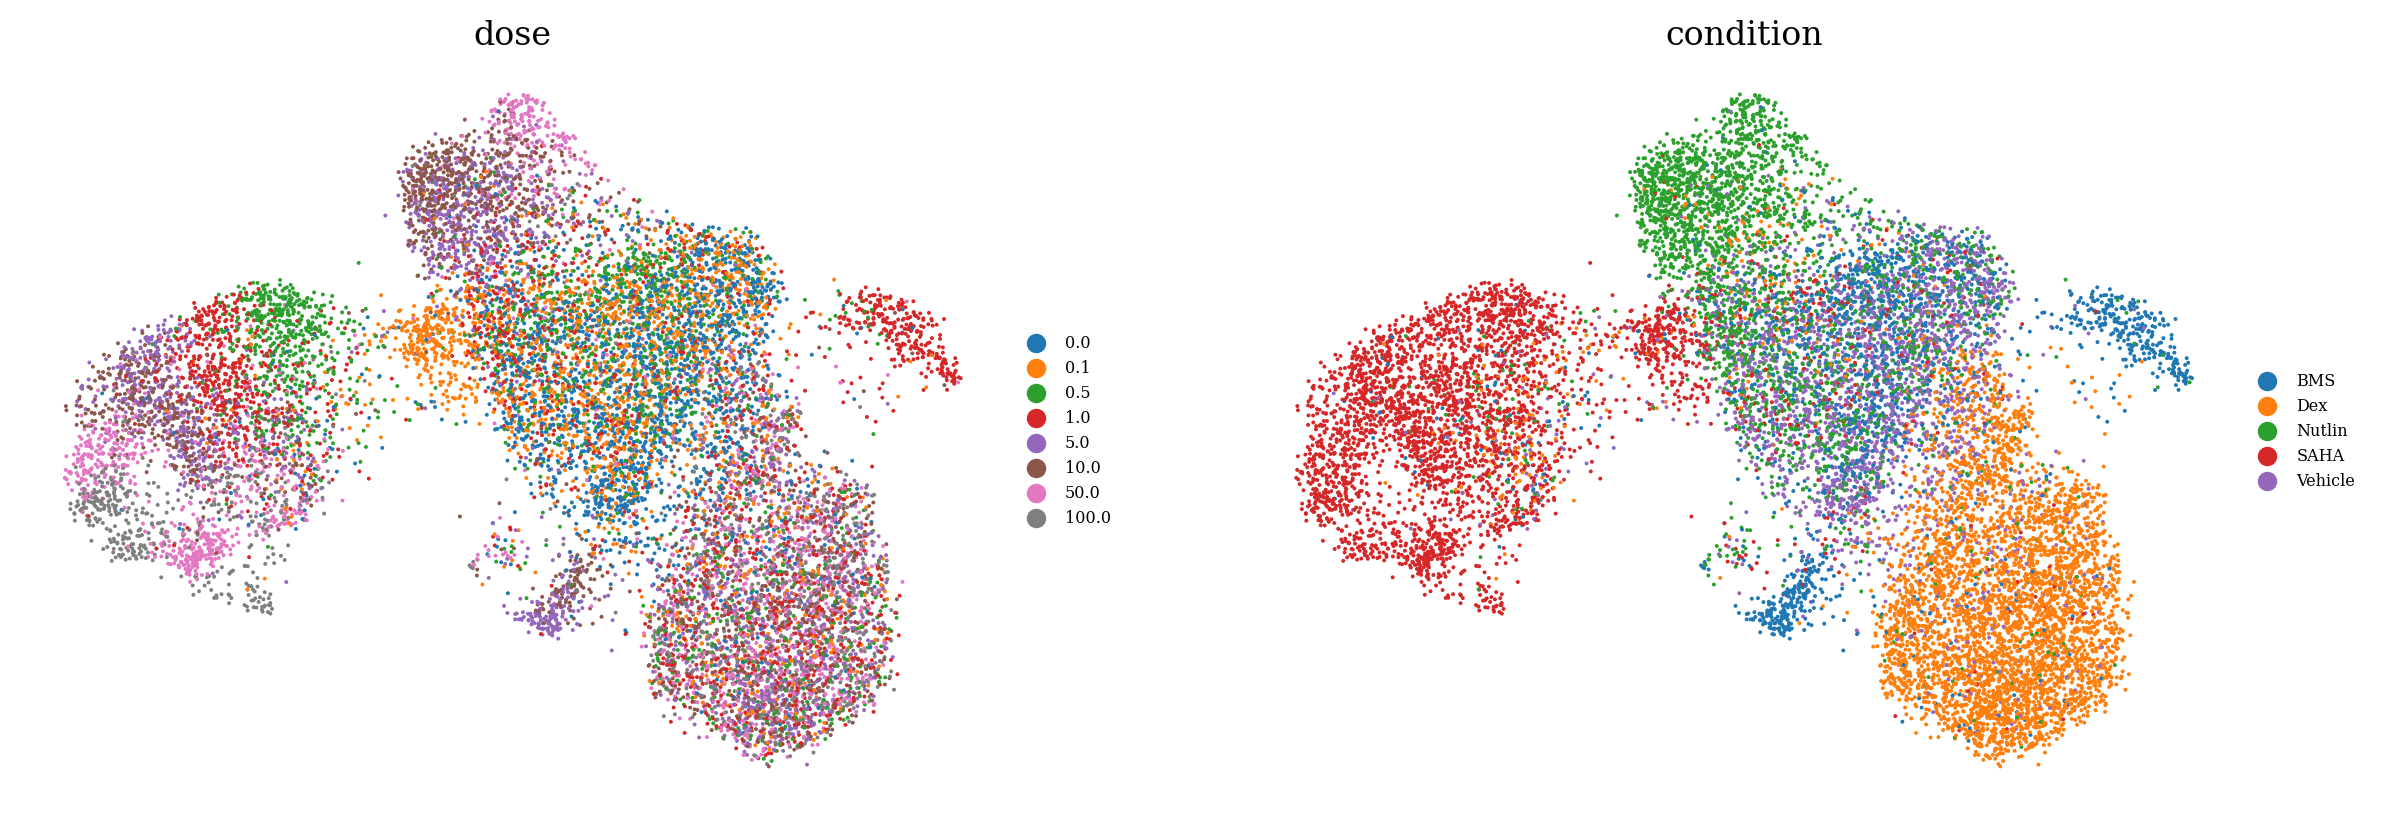

In [20]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

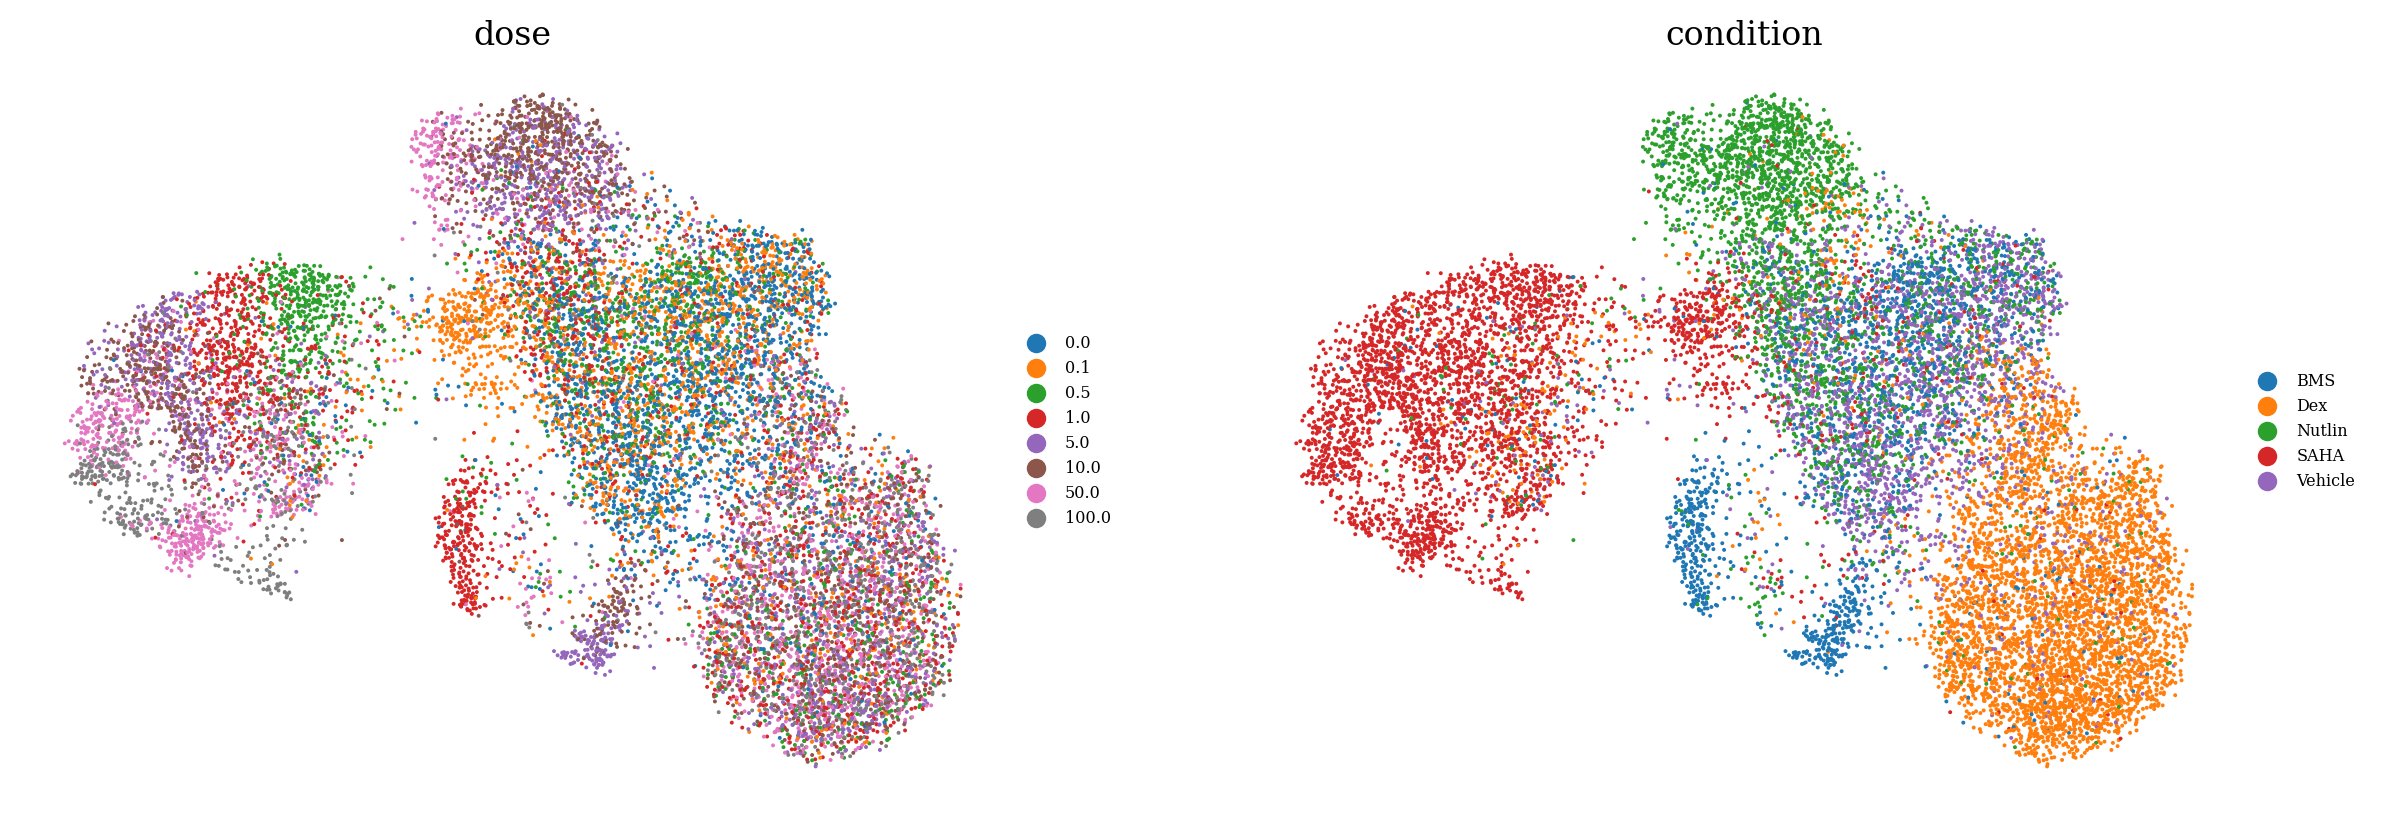

In [21]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [22]:
model.predict()

  0%|          | 0/463 [00:00<?, ?it/s]

  4%|▍         | 18/463 [00:00<00:02, 174.13it/s]

  9%|▉         | 43/463 [00:00<00:01, 214.04it/s]

 14%|█▍        | 67/463 [00:00<00:01, 224.20it/s]

 20%|█▉        | 92/463 [00:00<00:01, 230.55it/s]

 25%|██▌       | 117/463 [00:00<00:01, 234.52it/s]

 30%|███       | 141/463 [00:00<00:01, 236.12it/s]

 36%|███▌      | 166/463 [00:00<00:01, 237.60it/s]

 41%|████      | 190/463 [00:00<00:01, 238.18it/s]

 46%|████▋     | 215/463 [00:00<00:01, 239.22it/s]

 52%|█████▏    | 240/463 [00:01<00:00, 239.69it/s]

 57%|█████▋    | 265/463 [00:01<00:00, 239.97it/s]

 63%|██████▎   | 290/463 [00:01<00:00, 240.49it/s]

 68%|██████▊   | 315/463 [00:01<00:00, 240.60it/s]

 73%|███████▎  | 340/463 [00:01<00:00, 240.65it/s]

 79%|███████▉  | 365/463 [00:01<00:00, 239.97it/s]

 84%|████████▍ | 389/463 [00:01<00:00, 239.77it/s]

 89%|████████▉ | 413/463 [00:01<00:00, 239.79it/s]

 95%|█████████▍| 438/463 [00:01<00:00, 240.09it/s]

100%|██████████| 463/463 [00:01<00:00, 239.75it/s]

100%|██████████| 463/463 [00:01<00:00, 236.50it/s]

In [23]:
pred_adata = adata[model.test_indices].copy()
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [24]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.9864526378307605

In [25]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)